In [2]:
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import misc
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
import pickle
%matplotlib inline

Using TensorFlow backend.


In [6]:
test_img_fnames = os.listdir('data/test')
train_img_fnames = os.listdir('data/train')[:500]

# Load in the data
First we need to write a function to load into memory each of the images, and then resize them to (224, 224, 3). scipy.misc.imread and scipy.misc.imresize will be useful for this. You should also rescale the images so that they are on a scale of 0 to 1, meaning each pixel value should be between 0 and 1. This can be achieved by dividing by an appropriate constant.

In [7]:
def load_img(filename):
    ## YOUR CODE HERE
    img_arr = misc.imread(filename)
    img_arr_resized = misc.imresize(img_arr, (224, 224, 3))
    return np.divide(img_arr_resized, 255.0)

In [8]:
test_imgs = [load_img(os.path.join('data/test', fname)) for fname in test_img_fnames]
test_imgs = np.stack(test_imgs)

In [9]:
train_imgs = [load_img(os.path.join('data/train', fname)) for fname in train_img_fnames]
train_imgs = np.stack(train_imgs)

In [10]:
with open('data/train_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)

# Load Pretrained VGG network
Now in order to generate the CNN featurizations of our images we need to load a pretrained network. Note that running this network will take a long time on CPU so you can feel free to skip this section and just load the featurizations I provided in the next section

In [ ]:
VGG16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [ ]:
VGG16.summary()

In [ ]:
featurized_training_data = VGG16.predict(train_imgs, verbose=1)

In [ ]:
featurized_test_data = VGG16.predict(test_imgs, verbose=1)

In [ ]:
# Save featurizations
import pickle
with open('featurized_train_imgs.pkl', 'wb') as f:
    pickle.dump(featurized_training_data, f)
with open('featurized_test_imgs.pkl', 'wb') as f:
    pickle.dump(featurized_test_data, f)

# Load featurizations

In [12]:
import pickle
with open('data/featurized_train_imgs.pkl', 'rb') as f:
    featurized_training_data = pickle.load(f)
with open('data/featurized_test_imgs.pkl', 'rb') as f:
    featurized_test_data = pickle.load(f)

# Create you network
Now we need to create a network to take in the featurizations and output a label of dog or not dog. To do this you should use Keras' Sequential model. We will need to flatten our (7,7,512) feature input into a vector (HINT: lookup flatten in keras documentation) and then add a Dense layer with some number of neurons (play around with the number of neurons to improve your performance). Then finally we need a Dense layer with 1 neuron and a sigmoid activation to represent our label output. You might want to use more or less model.add calls than have been provided

In [48]:
model = Sequential()
model.add(Flatten(input_shape=(7, 7, 512)))
model.add(Dense(200, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               5017800   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 201       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 5,018,001
Trainable params: 5,018,001
Non-trainable params: 0
_________________________________________________________________


# Now we need to train the network
You need to compile the model first, and then use the fit function. You should use binary crossentropy as your loss.

In [50]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
model.fit(featurized_training_data, train_labels, epochs=20)

Epoch 1/20
10000/10000 [==============================] - 9s - loss: 0.2389 - acc: 0.8995     
Epoch 2/20
10000/10000 [==============================] - 9s - loss: 0.2234 - acc: 0.9082     
Epoch 3/20
10000/10000 [==============================] - 9s - loss: 0.1918 - acc: 0.9233     
Epoch 4/20
10000/10000 [==============================] - 9s - loss: 0.2133 - acc: 0.9104     
Epoch 5/20
10000/10000 [==============================] - 9s - loss: 0.1892 - acc: 0.9241     
Epoch 6/20
10000/10000 [==============================] - 9s - loss: 0.1916 - acc: 0.9202     
Epoch 7/20
10000/10000 [==============================] - 9s - loss: 0.1751 - acc: 0.9265     
Epoch 8/20
10000/10000 [==============================] - 9s - loss: 0.1659 - acc: 0.9327     
Epoch 9/20
10000/10000 [==============================] - 9s - loss: 0.1568 - acc: 0.9356     
Epoch 10/20
10000/10000 [==============================] - 10s - loss: 0.1593 - acc: 0.9355    
Epoch 11/20
10000/10000 [========================

Now we need to predict labels for the test set and output it to file. Use keras predict for this. Remember that the predictions are real values between 0 and 1 and you should be outputting just 0 or 1, not a value between.

In [53]:
predictions = model.predict(featurized_test_data)

In [54]:
with open('test_labels.txt', 'w') as f:
    f.write("Id,Label\n")
    for i, val in enumerate(predictions):
        prediction = 1 if val[0] >= 0.5 else 0
        f.write(str(i))
        f.write(',')
        f.write(str(prediction))
        f.write('\n')

# Part 2

In [1]:
from sklearn.decomposition import PCA

Now we want to run PCA on our images and our featurizations to see the difference. To save time we will just run it on the first 500 images. Take the first 500 images and 500 featurizations and reshape them into shape (500, x).

In [16]:
original_imgs = train_imgs[:500]
featurized = featurized_training_data[:500]
orig_s = original_imgs.shape[1:]
feat_s = featurized.shape[1:]
original_imgs = original_imgs.reshape(500, orig_s[0] * orig_s[1] * orig_s[2])
featurized = featurized.reshape(500, feat_s[0] * feat_s[1] * feat_s[2])

Run PCA with 2 components on the original images

In [17]:
pca_orig = PCA(n_components=2).fit(original_imgs)

Run PCA with 2 components on the featurizations

In [18]:
pca_featurized = PCA(n_components=2).fit(featurized)

Project the original images and featurizations onto the 2 principal components. (HINT: look at the PCA.transform function)

In [19]:
projected_orig_imgs = pca_orig.transform(original_imgs)
projected_featurized = pca_featurized.transform(featurized)

Find the indices of the labels that are cats and the indices that are dogs. np.where will make this very easy

In [20]:
labels = train_labels[:500]
cat_inds = np.where(labels == 0)
dog_inds = np.where(labels == 1)

Plot the PCA of the original images and the PCA of the featurization

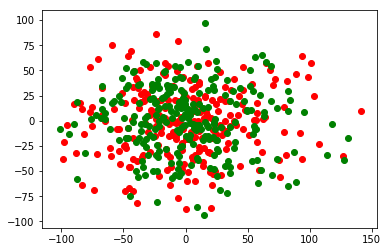

In [21]:
plt.scatter(projected_orig_imgs[cat_inds ,0], projected_orig_imgs[cat_inds, 1], c='red')
plt.scatter(projected_orig_imgs[dog_inds, 0], projected_orig_imgs[dog_inds, 1], c='green')

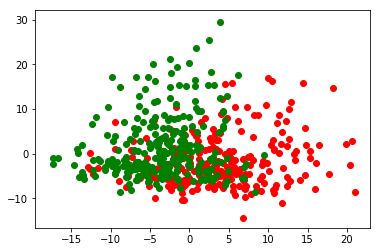

In [22]:
plt.scatter(projected_featurized[cat_inds ,0], projected_featurized[cat_inds, 1], c='red')
plt.scatter(projected_featurized[dog_inds, 0], projected_featurized[dog_inds, 1], c='green')

# Question 1:

The PCA of the raw images without featurization show that cats and dogs seem to be very similar at first, with the red dots showing the same cluster patterns as the green dots. However upon featurizing the images, we see that red and green dots separate a bit, meaning that our neural net was able to pick up on the peculiar features of cats and dogs that helped to distinguish the two.

# Question 2:

There are two possibilities to training a fully connected a model without first featurizing using a CNN. As we can see from the above PCA graphs, if we don't featurize a picture, it's very difficult to tell different categories apart using only the raw image. That's why if we were to train a brand new deeply layered model, we may in fact get the same results as this CNN, however the large number of layers means it will train very slowly, and all these slow layers are essentially just going to perform its own featurization. We can try to train with a shallow model but then we won't be able to featurize as extensively and will end up with a model with very poor results. Featurizing images using a CNN first allows us to transform our data into a much more informative sample space, which when passed through a fully connected model will allow us to gain much more accurate results m